In [1]:
import random
import torch
import matplotlib.pyplot as plt

# 完整的线性回归实现

In [51]:
# 构造一个数据集
def synthetic_data(w,b,num_examples):
    """生成y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1))
# 真实的w和b
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)

features: torch.Size([1000, 2]) 
label: tensor([4.0824])


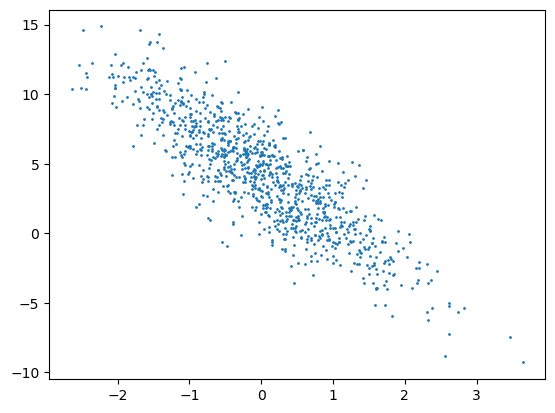

In [52]:
print('features:', features.shape,'\nlabel:',labels[0])
# 看一下样本
plt.scatter(features[:,1].detach().numpy(),
           labels.detach().numpy(),1)

In [53]:
# 接受批量大小，特征矩阵和标签向量，生成小批量样本
def data_iter(batch_size, feaetures, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 把下标打乱
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
    print(X,'\n',y)
    break

tensor([[ 0.4007, -0.9917],
        [ 0.8178,  0.0884],
        [ 2.2276,  0.2420],
        [ 0.2635, -1.2359],
        [ 1.2379, -0.8094],
        [ 1.2602, -0.2874],
        [ 0.0535,  3.4688],
        [-0.2681, -0.2726],
        [-0.3941,  0.6379],
        [ 0.0148,  0.0064]]) 
 tensor([[ 8.3812],
        [ 5.5494],
        [ 7.8519],
        [ 8.9372],
        [ 9.4145],
        [ 7.6954],
        [-7.4816],
        [ 4.5901],
        [ 1.2271],
        [ 4.2104]])


In [60]:
# 定义初始化模型参数
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [55]:
# 定义模型
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b

In [56]:
# 定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [57]:
# 优化算法
def sgd(params,lr,batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            # 防止累积梯度
            param.grad.zero_()

In [61]:
# 训练
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b), y)
        # 因为l的形状是(batch_size, 1)，而不是一个标量
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.036133
epoch 2, loss 0.000125
epoch 3, loss 0.000050
epoch 4, loss 0.000050
epoch 5, loss 0.000050
epoch 6, loss 0.000050
epoch 7, loss 0.000050
epoch 8, loss 0.000050
epoch 9, loss 0.000050
epoch 10, loss 0.000050


In [62]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0003, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


# 调库版

In [76]:
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b,1000)

In [77]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 1.7326, -1.2675],
         [-0.2990, -0.1304],
         [-0.1770,  0.2699],
         [-0.3366,  1.6301],
         [ 0.9851, -1.6781],
         [ 0.8341, -0.1431],
         [ 0.6127,  1.0725],
         [ 0.0206,  1.2832],
         [ 0.6759,  1.2441],
         [-0.5705, -0.7812]]),
 tensor([[11.9743],
         [ 4.0481],
         [ 2.9315],
         [-2.0055],
         [11.8844],
         [ 6.3471],
         [ 1.7967],
         [-0.1521],
         [ 1.3047],
         [ 5.7088]])]

In [78]:
# 模型定义
from torch import nn
net = nn.Sequential(nn.Linear(2,1))

In [79]:
# 初始化模型参数
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [80]:
loss = nn.MSELoss()

In [81]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [82]:
num_epochs = 3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000279
epoch 2, loss 0.000102
epoch 3, loss 0.000103
